In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pylab as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd

def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)


def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)


def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

def BlackScholesVanillaCall(S, K, r, sigma, T):
    if T == 0 : #prevent divide by 0
        T = 0.00001
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


In [2]:
paths = 50000
N = 21 #21
steps = N
maturity = 1.0

r = 0.05
S0 = 100.0
K = 100.0
sigma = 0.2

#
T, W_T = simulate_Brownian_Motion(paths, steps, maturity)
dt = maturity / steps
blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])

C:\Users\Bryan Seah\AppData\Local\Temp\ipykernel_15600\2647277953.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
C:\Users\Bryan Seah\AppData\Local\Temp\ipykernel_15600\2647277953.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


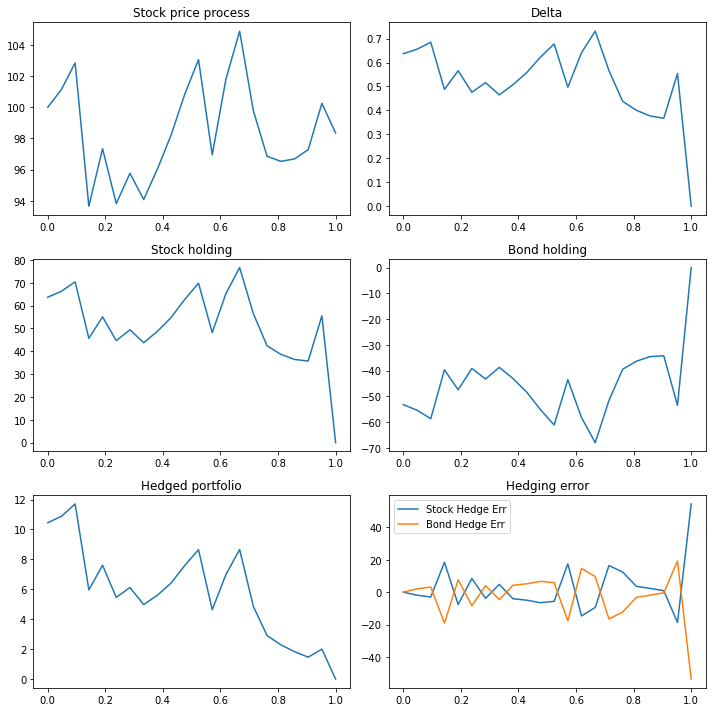

In [3]:
deltas = []
stockhedge_errors = []
bondhedge_errors = []
hedged_portfolios = []
stock_holdings = []
bond_holdings = []
for t, S_t in zip(T, blackscholespath):
    stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
    bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
    V_t = stock_pos + bond_pos
    stock_holdings.append(stock_pos)
    bond_holdings.append(bond_pos)
    hedged_portfolios.append(V_t)
    deltas.append(phi(S_t, K, r, sigma, maturity-t))
    if t == 0.0:
        stockhedge_errors.append(0)
        bondhedge_errors.append(0)
    else:
        stockhedge_errors.append(prev_phi*S_t - stock_pos)
        bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

    prev_phi = phi(S_t, K, r, sigma, maturity-t)
    prev_bond_pos = bond_pos

plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(321)
plt.plot(T, blackscholespath)
plt.title('Stock price process')
plt.subplot(322)
plt.plot(T, deltas)
plt.title('Delta')
plt.subplot(323)
plt.plot(T, stock_holdings)
plt.title('Stock holding')
plt.subplot(324)
plt.plot(T, bond_holdings)
plt.title('Bond holding')
plt.subplot(325)
plt.plot(T, hedged_portfolios)
plt.title('Hedged portfolio')
plt.subplot(326)
plt.plot(T, stockhedge_errors, label='Stock Hedge Err')
plt.plot(T, bondhedge_errors, label='Bond Hedge Err')
plt.legend()
plt.title('Hedging error')
plt.show()

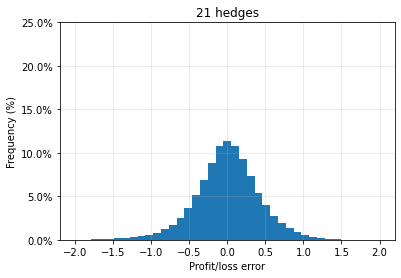

Call option is 2.5120670860398846
Mean is 3.186369283446381e-05
Standard Deviation is 0.427688918823711
Standard Deviation of P&L as a % of option premium 0.1702537807212528


In [4]:
T = 1/12
dt = T / steps
hedging_error = 0
t, W_T = simulate_Brownian_Motion(paths, steps, T)
stock_price = S0*np.exp((r-sigma**2/2)*t + sigma*W_T)
for i in range(N):
    S_t = stock_price[:,i]
    S_t1 = stock_price[:,i+1]
    delta_t = T-t[i]
    Phi = phi(S_t, K, r, sigma, delta_t)
    Bt_Psi = psi_Bt(S_t, K, r, sigma, delta_t)
    hedging_error += (S_t1*Phi+Bt_Psi*np.exp(r*dt))-(S_t*Phi+Bt_Psi)
call_option = BlackScholesVanillaCall(S0, K, r, sigma, T)
hedging_error = hedging_error + call_option - np.maximum(stock_price[:,N]-K, 0)
mean_of_21_hedge_times = hedging_error.mean()
std_of_21_hedge_times = hedging_error.std()
percent_of_21_hedge_times = std_of_21_hedge_times / call_option
price_check=S0*np.exp(r*T)
w=np.ones(len(hedging_error))/len(hedging_error)
plt.hist(hedging_error, weights=w, bins=np.linspace(-2,2,40))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel("Profit/loss error")
plt.ylabel("Frequency (%)")
plt.title('21 hedges')
plt.grid(alpha = 0.3)
plt.ylim(0,0.25)
plt.show()

print("Call option is", call_option)
print("Mean is", mean_of_21_hedge_times)
print("Standard Deviation is", std_of_21_hedge_times)
print("Standard Deviation of P&L as a % of option premium", percent_of_21_hedge_times)

C:\Users\Bryan Seah\AppData\Local\Temp\ipykernel_15600\2647277953.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
C:\Users\Bryan Seah\AppData\Local\Temp\ipykernel_15600\2647277953.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


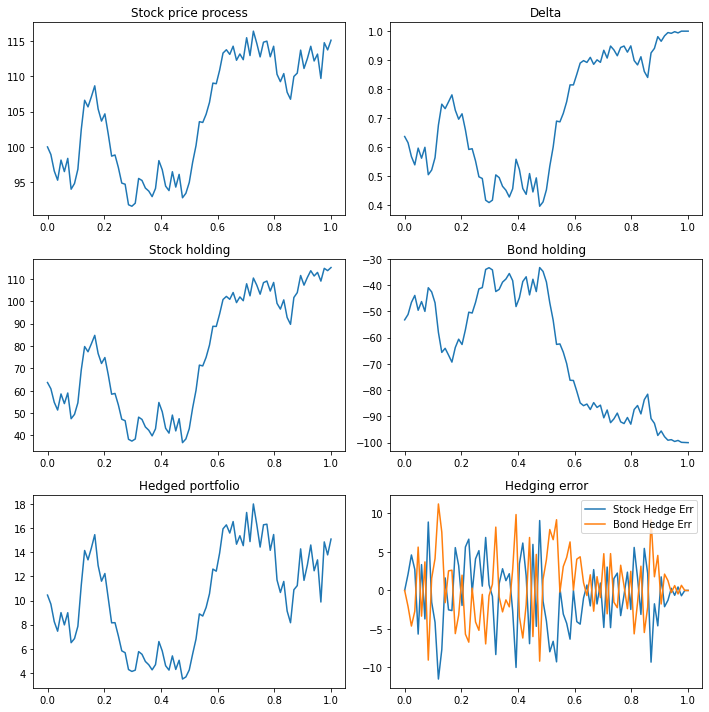

In [5]:
paths = 50000
N = 84
steps = N
maturity = 1.0

r = 0.05
S0 = 100.0
K = 100.0
sigma = 0.2

T, W_T = simulate_Brownian_Motion(paths, steps, maturity)
dt = maturity / steps
blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])

deltas = []
stockhedge_errors = []
bondhedge_errors = []
hedged_portfolios = []
stock_holdings = []
bond_holdings = []
for t, S_t in zip(T, blackscholespath):
    stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
    bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
    V_t = stock_pos + bond_pos
    stock_holdings.append(stock_pos)
    bond_holdings.append(bond_pos)
    hedged_portfolios.append(V_t)
    deltas.append(phi(S_t, K, r, sigma, maturity-t))
    if t == 0.0:
        stockhedge_errors.append(0)
        bondhedge_errors.append(0)
    else:
        stockhedge_errors.append(prev_phi*S_t - stock_pos)
        bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

    prev_phi = phi(S_t, K, r, sigma, maturity-t)
    prev_bond_pos = bond_pos

plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(321)
plt.plot(T, blackscholespath)
plt.title('Stock price process')
plt.subplot(322)
plt.plot(T, deltas)
plt.title('Delta')
plt.subplot(323)
plt.plot(T, stock_holdings)
plt.title('Stock holding')
plt.subplot(324)
plt.plot(T, bond_holdings)
plt.title('Bond holding')
plt.subplot(325)
plt.plot(T, hedged_portfolios)
plt.title('Hedged portfolio')
plt.subplot(326)
plt.plot(T, stockhedge_errors, label='Stock Hedge Err')
plt.plot(T, bondhedge_errors, label='Bond Hedge Err')
plt.legend()
plt.title('Hedging error')
plt.show()

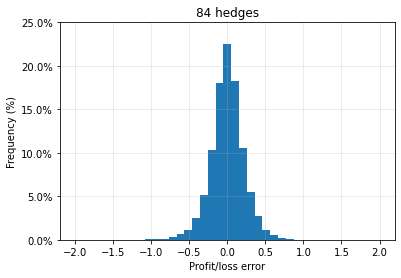

Call option is 2.5120670860398846
Mean is 0.00012001108866974764
Standard Deviation is 0.2179124023614476
Standard Deviation of P&L as a % of option premium 0.08674625115405368


In [6]:
T = 1/12
dt = T / steps
hedging_error = 0
t, W_T = simulate_Brownian_Motion(paths, steps, T)
stock_price = S0*np.exp((r-sigma**2/2)*t + sigma*W_T)
for i in range(N):
    S_t = stock_price[:,i]
    S_t1 = stock_price[:,i+1]
    delta_t = T-t[i]
    Phi = phi(S_t, K, r, sigma, delta_t)
    Bt_Psi = psi_Bt(S_t, K, r, sigma, delta_t)
    hedging_error += (S_t1*Phi+Bt_Psi*np.exp(r*dt))-(S_t*Phi+Bt_Psi)
call_option = BlackScholesVanillaCall(S0, K, r, sigma, T)
hedging_error = hedging_error + call_option - np.maximum(stock_price[:,N]-K, 0)
mean_of_84_hedge_times = hedging_error.mean()
std_of_84_hedge_times = hedging_error.std()
percent_of_84_hedge_times = std_of_84_hedge_times / call_option
price_check=S0*np.exp(r*T)
w=np.ones(len(hedging_error))/len(hedging_error)
plt.hist(hedging_error, weights=w, bins=np.linspace(-2,2,40))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel("Profit/loss error")
plt.ylabel("Frequency (%)")
plt.title('84 hedges')
plt.grid(alpha = 0.3)
plt.ylim(0,0.25)
plt.show()

print("Call option is", call_option)
print("Mean is", mean_of_84_hedge_times)
print("Standard Deviation is", std_of_84_hedge_times)
print("Standard Deviation of P&L as a % of option premium", percent_of_84_hedge_times)

In [7]:
result = pd.DataFrame()
result["Hedges"] = [21 , 84]
result["Mean P&L"] = [mean_of_21_hedge_times, mean_of_84_hedge_times]
result["Standard Deviation of P&L"] = [std_of_21_hedge_times, std_of_84_hedge_times]
result["Standard Deviation of P&L(%) of option premium"] = [percent_of_21_hedge_times*100, percent_of_84_hedge_times*100]
result

,Hedges,Mean P&L,Standard Deviation of P&L,Standard Deviation of P&L(%) of option premium
0,21,0.000032,0.427689,17.025378
1,84,0.000120,0.217912,8.674625
